# KKProject_3_Modelling

In this notebook, I'll use different clustering mechanisms to see if I can get anything useful out of the data that I have.

# Libraries

In [173]:
# file management
import os

# mathematical
import numpy as np
from scipy.spatial.distance import cdist 

# data exploration
import pandas as pd

# plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm

# preprocessing

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer

# modelling

from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans

# Cluster Class

In [131]:
class Cluster:
    def __init__(self,df,):
        self.df = df

class K_Means(Cluster):
    pass
    
class SupportVector(Cluster):
    pass

class iForest(Cluster):
    pass

class density(Cluster):
    pass


# Dataset

Note the following:
- acceleration is measured in units of 'g'
- gyration (angular velocity) has units of degrees per second
- data has only been recorded for one hour, and as such may not be representative
- a 'resting' object should feel an acceleration of about 1 'g'

In [132]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
path = '/Users/yousefnami/KinKeepers/ProjectAI/Data/Ignacio/'
frames = []
for filename in os.listdir(path):
    if '.csv' in filename:
        frames.append(pd.read_csv(path+filename))

df = pd.concat(frames,ignore_index = True)
df['accTotal'] = np.sqrt(np.power(df[['accX','accY','accZ']],2).sum(axis = 1))
df['gyrTotal'] = np.sqrt(np.power(df[['gyrX','gyrY','gyrZ']],2).sum(axis = 1))

df.head()

,date,accX,accY,accZ,gyrX,gyrY,gyrZ,fall,accTotal,gyrTotal
0,2020-09-02 21:07:57,0.00,0.00,0.87,0.68,0.87,0.35,0.0,0.870000,1.158361
1,2020-09-02 21:07:58,0.30,0.36,0.87,0.74,0.92,0.39,0.0,0.988180,1.243423
2,2020-09-02 21:08:00,0.29,0.36,0.87,0.98,1.81,1.61,0.0,0.985190,2.613159
3,2020-09-02 21:08:01,0.29,0.37,0.87,3.25,4.33,2.01,0.0,0.988888,5.775076
4,2020-09-02 21:08:02,0.24,0.36,0.89,9.07,6.16,6.25,0.0,0.989596,12.620341


# Data Exploration / Visualization Part I

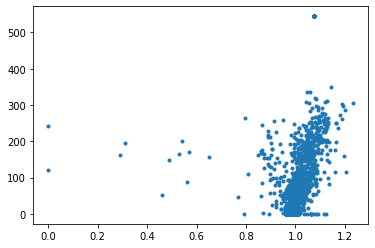

In [133]:
plt.plot(df.accTotal,df.gyrTotal,'.')
plt.show()

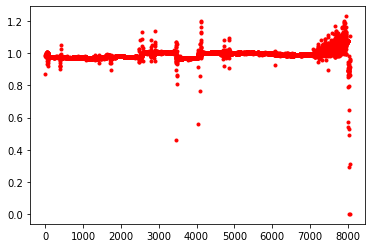

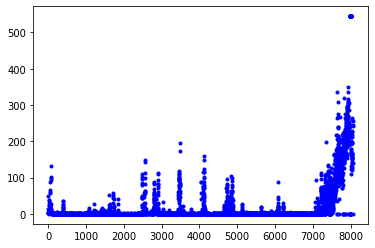

In [134]:
plt.plot(df.index,df.accTotal,'r.')
plt.show()
plt.plot(df.index,df.gyrTotal,'b.')
plt.show()



In [137]:
dates = matplotlib.dates.date2num(df.date.values)
plt.plot_date(dates, df.accTotal)

#note sure why, but the plot does not seem to be great

""" needs to be fixed """

NameError: name 'matplotlib' is not defined

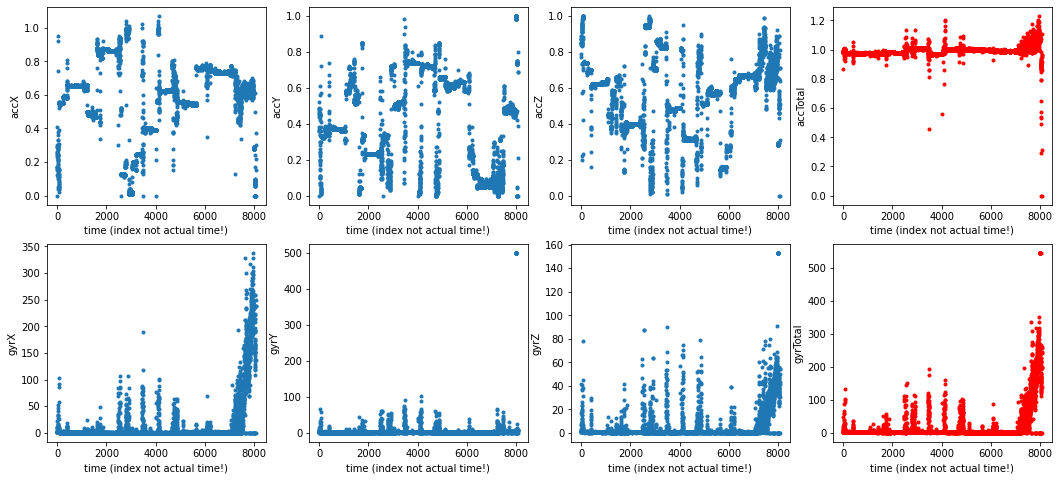

In [138]:
plots = ['X','Y','Z','Total']
plt.figure(figsize=(18,8))
i = 1
for parameter in ['acc','gyr']:
    for plot in plots:
        plt.subplot(int('24{}'.format(i)))
        if plot == 'Total':
            plt.plot(df.index,df['{}{}'.format(parameter,plot)],'r.')
        else:
            plt.plot(df.index,df['{}{}'.format(parameter,plot)],'.')
        plt.ylabel('{}{}'.format(parameter,plot))
        plt.xlabel('time (index not actual time!)')
        i+=1
plt.show()

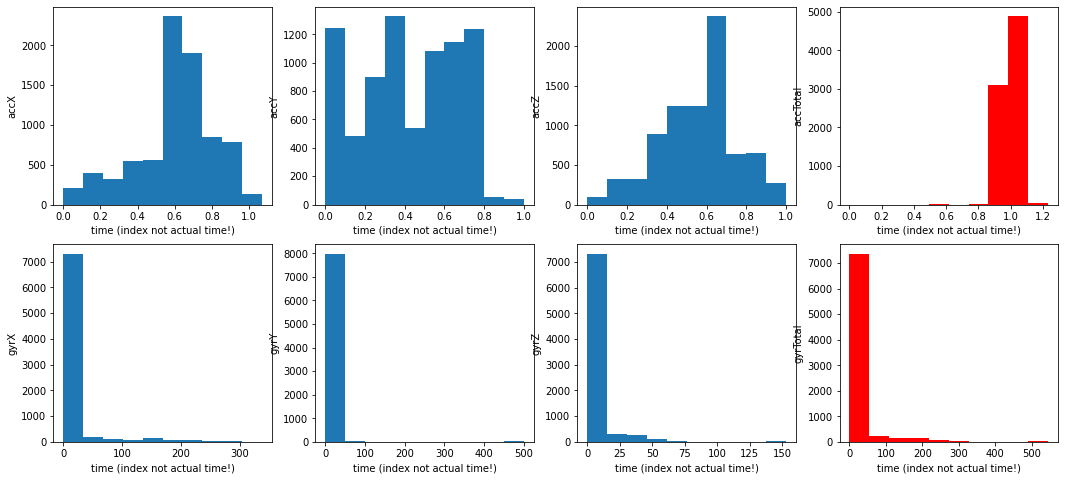

In [139]:
plots = ['X','Y','Z','Total']
plt.figure(figsize=(18,8))
i = 1
for parameter in ['acc','gyr']:
    for plot in plots:
        plt.subplot(int('24{}'.format(i)))
        if plot == 'Total':
            plt.hist(df['{}{}'.format(parameter,plot)],color = 'red')
        else:
            plt.hist(df['{}{}'.format(parameter,plot)])
        plt.ylabel('{}{}'.format(parameter,plot))
        plt.xlabel('time (index not actual time!)')
        i+=1

Based on the exploration done here, it would appear that the data is difficult to deal with. Here are some thoughts:

- the gyration vs. accleration graph does not show any nicely shaped clusters
- It might be worth determining whether gyration is in fact a parameter worthy of consideration for this exercise: does it really say much about whether the movement is significant? (Rohan)
- None of the graphs (time series) show 'clear' clusters
- The data is very much skewed: gyrations are mostly zero, and accelerations are centred around 0.96 (as this would appear to be 'stationary'). It is likely that a person spends most of their day sitting, so the data points for 'significant movement' will be low; the clustering technique used must account for this (perhaps using an outlier detection algorithm is best?)
- It's worth noting that total acceleration should not have a 'normal distribution', since you cannot have accelerations lower than that of about 1 g (since that is 'stationary'). As such, it might be worth filtering the lower end of the data when it comes to this (this would lead to a right skewed histogram, which **could** be fixed by a log transform)

# Data Exploration / Visualization Part II

In [140]:
median = df.accTotal.median()
iqr = df.accTotal.quantile(0.75) -df.accTotal.quantile(0.25)

df2 = df.copy()
df2 = df2[df2.accTotal >= median-iqr]
df2.shape

(7844, 10)

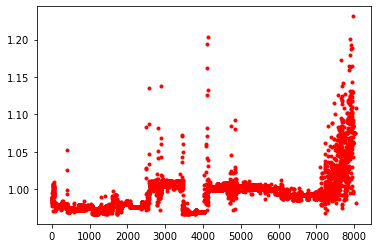

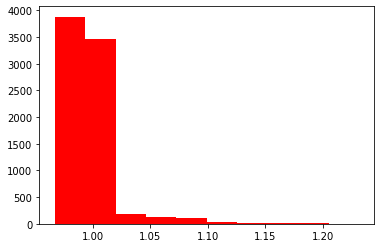

In [141]:
plt.plot(df2.index,df2.accTotal,'r.')
plt.show()

plt.hist(df2.accTotal,color = 'r')
plt.show()
#appears to be more 'normal'

# Modelling attempt using DBSCAN

Meaning of the metrics:
- *eps* is the max distance between two samples for one to be considered a 'neighborhood' of the other (so kind of like radius of the cluster)
- *min_samples* number of points ina  neighborhood to consider a central point the 'core point'
- *metric* chooses the type of distance
- *p* is the power parameter in the minkowski distance equation

In [142]:
%%latex
\begin{align}
\mathrm{Minkowski \,distance} = \left( 
    \sum_{i=1}^{n}|X_i - Y_i|^p
    \right)^\frac{1}{p}
\end{align}

<IPython.core.display.Latex object>

In [143]:
X = StandardScaler().fit_transform(np.asarray(df2.accTotal).reshape(-1,1))
model = DBSCAN(eps = 0.5,min_samples = 110, metric = 'minkowski', p = 1.5).fit(X)
model.labels_
true_false = []
for item in model.labels_:
    if item == 0:
        true_false.append(False)
    else:
        true_false.append(True)
        
anomalies = df2[true_false]
actuals = df2[[not i for i in true_false]]

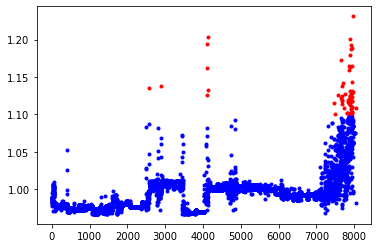

In [144]:
plt.plot(anomalies.index,anomalies.accTotal,'r.')
plt.plot(actuals.index,actuals.accTotal,'b.')

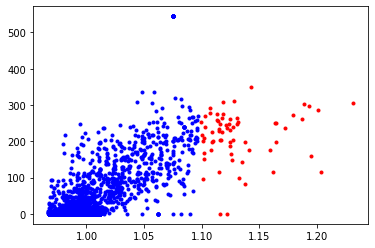

In [145]:
plt.plot(anomalies.accTotal,anomalies.gyrTotal,'r.')
plt.plot(actuals.accTotal,actuals.gyrTotal,'b.')
#this is a better plot than the scatter plot sketched before, it seems to suggest 1 important thing:
#gyration might actually be an important element to consider. There is a very large cluster between 0.95-1 on the
#x axis and 0 100 on the y axis? Let's explore this using Isolation forest, K means, DBSCAN, SVM

# Transforming data to create distinct clusters

In [146]:
X = df2[['gyrTotal','accTotal']].values
y_full = df2['accTotal'].values
distributions = [
    ('Unscaled data', X),
    ('Data after standard scaling',
        StandardScaler().fit_transform(X)),
    ('Data after min-max scaling',
        MinMaxScaler().fit_transform(X)),
    ('Data after max-abs scaling',
        MaxAbsScaler().fit_transform(X)),
    ('Data after power transformation (Yeo-Johnson)',
     PowerTransformer(method='yeo-johnson').fit_transform(X)),
    ('Data after robust scaling',
        RobustScaler(quantile_range=(25, 75)).fit_transform(X)),
    #('Data after power transformation (Box-Cox)',
    # PowerTransformer(method='box-cox').fit_transform(X)),
    ('Data after quantile transformation (gaussian pdf)',
        QuantileTransformer(output_distribution='normal')
        .fit_transform(X)),
    ('Data after quantile transformation (uniform pdf)',
        QuantileTransformer(output_distribution='uniform')
        .fit_transform(X)),
    ('Data after sample-wise L2 normalizing',
        Normalizer().fit_transform(X)),
]

# scale the output between 0 and 1 for the colorbar
y = minmax_scale(y_full)

# plasma does not exist in matplotlib < 1.5
cmap = getattr(cm, 'plasma_r', cm.hot_r)

def create_axes(title, figsize=(16, 6)):
    fig = plt.figure(figsize=figsize)
    fig.suptitle(title)

    # define the axis for the first plot
    left, width = 0.1, 0.22
    bottom, height = 0.1, 0.7
    bottom_h = height + 0.15
    left_h = left + width + 0.02

    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom_h, width, 0.1]
    rect_histy = [left_h, bottom, 0.05, height]

    ax_scatter = plt.axes(rect_scatter)
    ax_histx = plt.axes(rect_histx)
    ax_histy = plt.axes(rect_histy)

    # define the axis for the zoomed-in plot
    left = width + left + 0.2
    left_h = left + width + 0.02

    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom_h, width, 0.1]
    rect_histy = [left_h, bottom, 0.05, height]

    ax_scatter_zoom = plt.axes(rect_scatter)
    ax_histx_zoom = plt.axes(rect_histx)
    ax_histy_zoom = plt.axes(rect_histy)

    # define the axis for the colorbar
    left, width = width + left + 0.13, 0.01

    rect_colorbar = [left, bottom, width, height]
    ax_colorbar = plt.axes(rect_colorbar)

    return ((ax_scatter, ax_histy, ax_histx),
            (ax_scatter_zoom, ax_histy_zoom, ax_histx_zoom),
            ax_colorbar)


def plot_distribution(axes, X, y, hist_nbins=50, title="",
                      x0_label="", x1_label=""):
    ax, hist_X1, hist_X0 = axes

    ax.set_title(title)
    ax.set_xlabel(x0_label)
    ax.set_ylabel(x1_label)

    # The scatter plot
    colors = cmap(y)
    ax.scatter(X[:, 0], X[:, 1], alpha=0.5, marker='o', s=5, lw=0, c=colors)

    # Removing the top and the right spine for aesthetics
    # make nice axis layout
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))

    # Histogram for axis X1 (feature 5)
    hist_X1.set_ylim(ax.get_ylim())
    hist_X1.hist(X[:, 1], bins=hist_nbins, orientation='horizontal',
                 color='grey', ec='grey')
    hist_X1.axis('off')

    # Histogram for axis X0 (feature 0)
    hist_X0.set_xlim(ax.get_xlim())
    hist_X0.hist(X[:, 0], bins=hist_nbins, orientation='vertical',
                 color='grey', ec='grey')
    hist_X0.axis('off')
    
def make_plot(item_idx):
    title, X = distributions[item_idx]
    ax_zoom_out, ax_zoom_in, ax_colorbar = create_axes(title)
    axarr = (ax_zoom_out, ax_zoom_in)
    plot_distribution(axarr[0], X, y, hist_nbins=200,
                      x0_label="Acceleration (Total)",
                      x1_label="Gyration (Total)",
                      title="Full data")

    # zoom-in
    zoom_in_percentile_range = (0, 99)
    cutoffs_X0 = np.percentile(X[:, 0], zoom_in_percentile_range)
    cutoffs_X1 = np.percentile(X[:, 1], zoom_in_percentile_range)

    non_outliers_mask = (
        np.all(X > [cutoffs_X0[0], cutoffs_X1[0]], axis=1) &
        np.all(X < [cutoffs_X0[1], cutoffs_X1[1]], axis=1))
    plot_distribution(axarr[1], X[non_outliers_mask], y[non_outliers_mask],
                      hist_nbins=50,
                      x0_label="Acceleration (Total)",
                      x1_label="Gyration (Total)",
                      title="Zoom-in")

    norm = mpl.colors.Normalize(y_full.min(), y_full.max())
    mpl.colorbar.ColorbarBase(ax_colorbar, cmap=cmap,
                              norm=norm, orientation='vertical',
                              label='Color mapping for values of y')

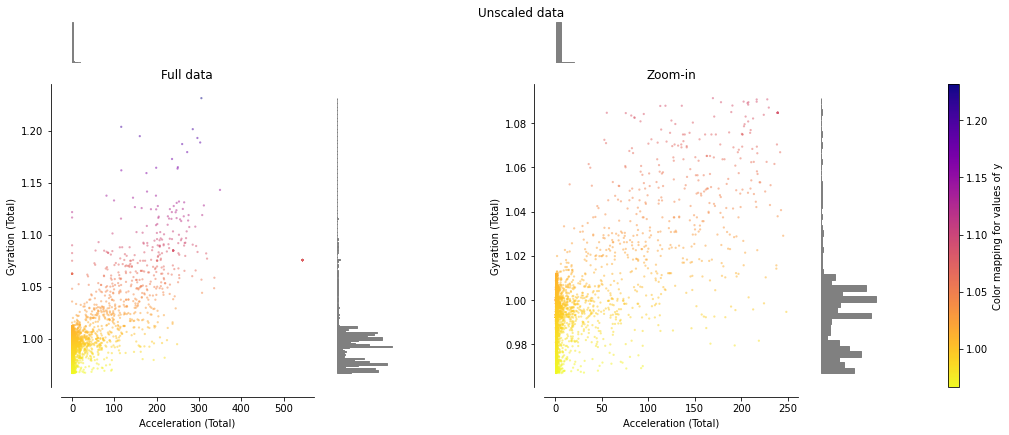

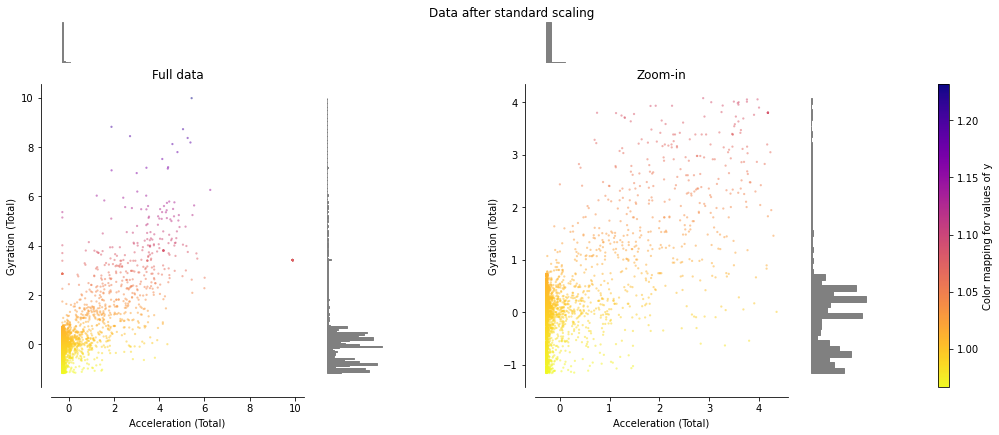

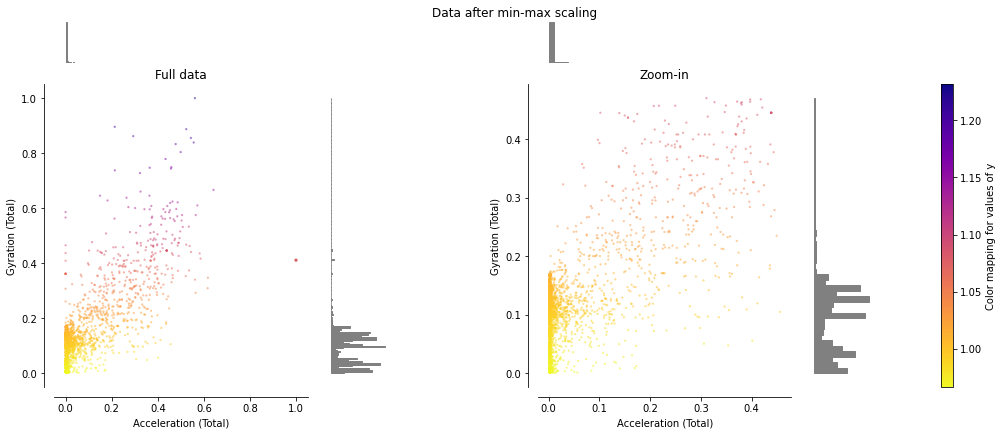

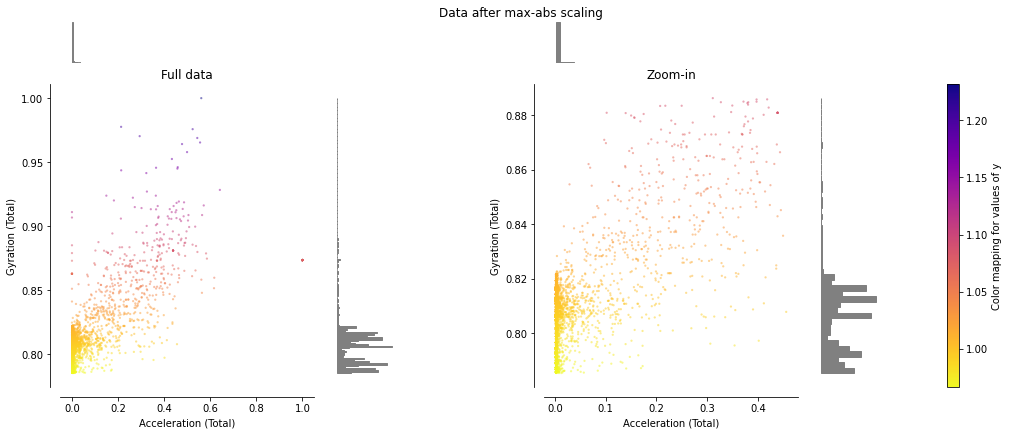

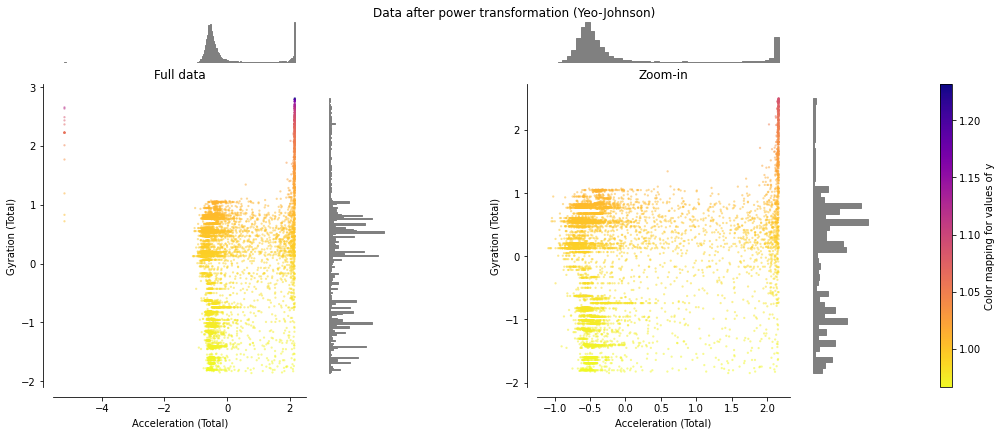

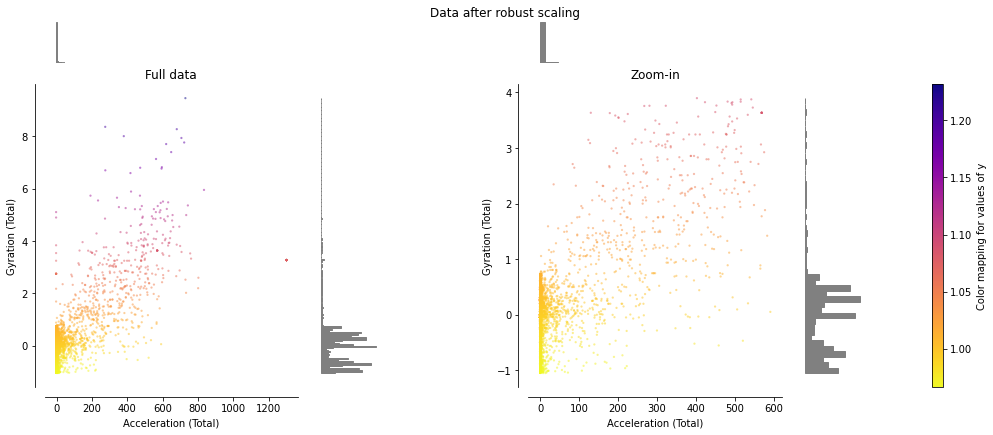

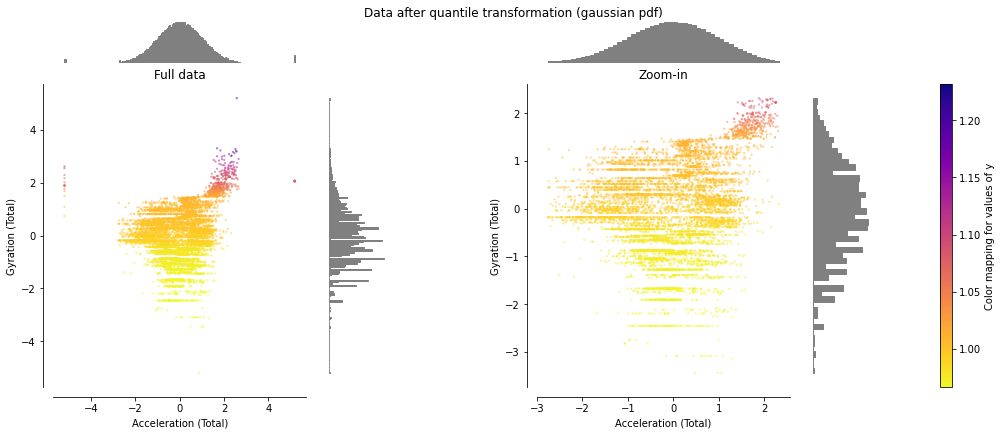

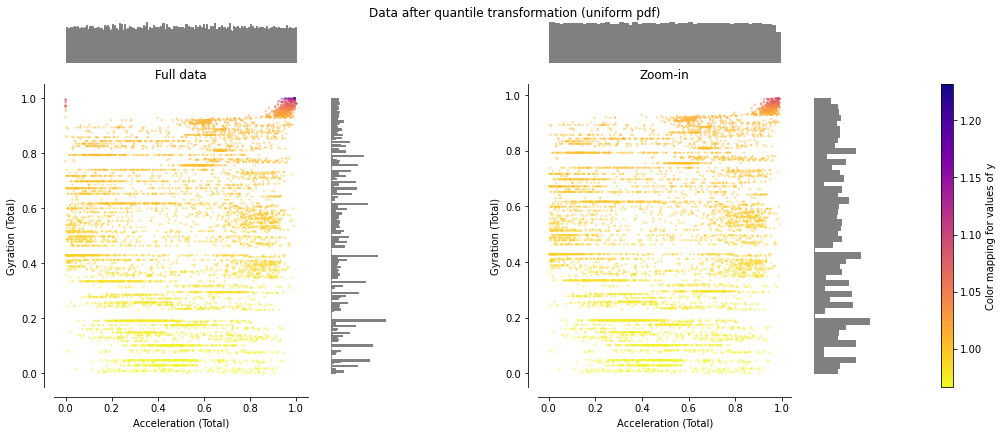

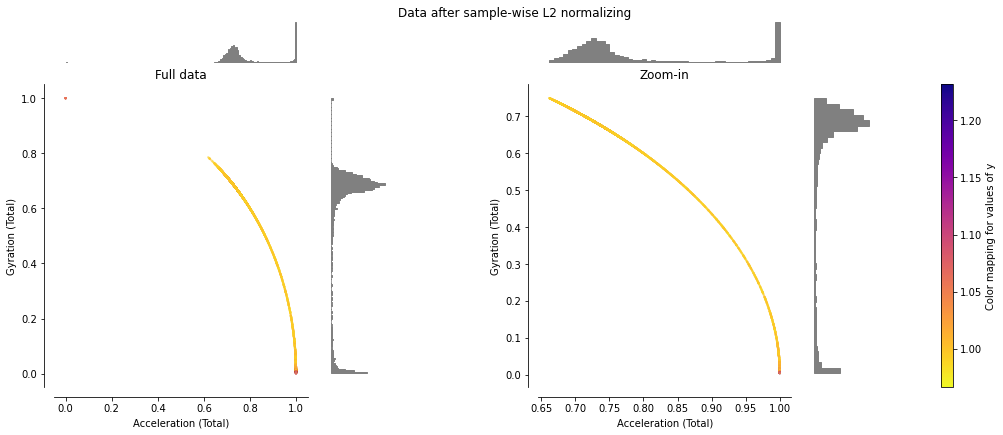

In [147]:
for i in range(len(distributions)):
    make_plot(i)

From the graphs above, it seems to me that the **QuantileTransformer(output_distribution='guassian')** does an OK job creating two distinct clusters. The next step would be to explore whether the output data creates a reasonable model.

# Further modelling

An attempt to cluster a Normally transformed dataset to see if it's a good idea or not.

Thoughts:

- Should practice using 'Pipeline' from sklearn, might make the process faster
- Online resources do not seem to suggest that there would be any problem doing a normal transformation on the accleration and gyration, especially given the fact that they are independent
- The normally transformed data showed 2 distinct clusters, but is clearly heavily influenced by gyration. Reason suggests that acceleration should be the variable that heavily influences 

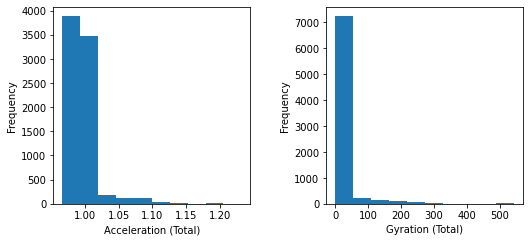

In [148]:
#before the transformation

X = df2[['accTotal','gyrTotal']].values

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.hist(X[:,0])
plt.xlabel('Acceleration (Total)')
plt.ylabel('Frequency')

plt.subplot(1,2,2)
plt.hist(X[:,1])
plt.xlabel('Gyration (Total)')
plt.ylabel('Frequency')


plt.tight_layout(pad=3)
plt.show()

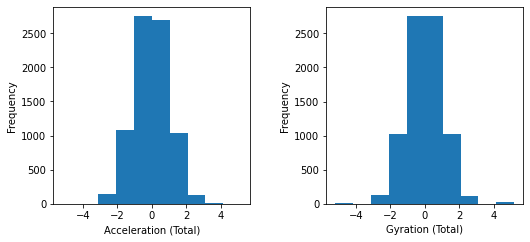

In [149]:
 
normalizer =  QuantileTransformer(output_distribution='normal')
X_normal = normalizer.fit_transform(X)
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.hist(X_normal[:,0])
plt.xlabel('Acceleration (Total)')
plt.ylabel('Frequency')

plt.subplot(1,2,2)
plt.hist(X_normal[:,1])
plt.xlabel('Gyration (Total)')
plt.ylabel('Frequency')


plt.tight_layout(pad=3)
plt.show()

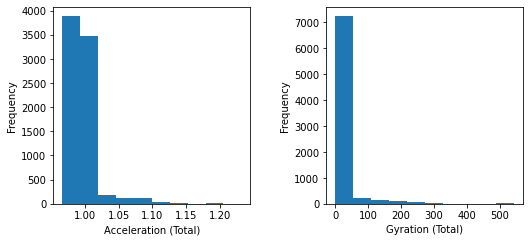

In [150]:
# inverse transform (to verify that it works)

X = normalizer.inverse_transform(X_normal)

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.hist(X[:,0])
plt.xlabel('Acceleration (Total)')
plt.ylabel('Frequency')

plt.subplot(1,2,2)
plt.hist(X[:,1])
plt.xlabel('Gyration (Total)')
plt.ylabel('Frequency')


plt.tight_layout(pad=3)
plt.show()

In [151]:
""" Code copied from before """


class Cluster:
    """ Class to automate mass clustering and evaluation. Currently only supports Kmeans """
    def __init__(self,X,labels):
        self.X = X
        self.labels = labels
    
    def save(self,path):
        with open (path,"wb") as f:
            pickle.dump(self.model,f)
            
            
class K_Mean_Clustering(Cluster):
    def __init__(self,X,labels):
        super().__init__(X,labels)
        self.model = None
        self.n_clusters = None
        
    def FitModel(self,n_clusters = 2, n_init = 12):
        k_means = KMeans(init = "k-means++", n_clusters = n_clusters, n_init = n_init)
        self.n_clusters = n_clusters
        self.model = k_means.fit(self.X)
    
    def plot(self,x_axis=0,y_axis=1):
        fig = plt.figure(figsize=(6,4))
        colors = plt.cm.Spectral(np.linspace(0,1,len(set(self.model.labels_))))
        ax = fig.add_subplot(1,1,1)
        for k,col in zip(range(self.n_clusters),colors):
            my_clusters = (self.model.labels_ == k) 
            cluster_center = self.model.cluster_centers_[k]
            ax.plot(self.X[my_clusters, x_axis], self.X[my_clusters, y_axis], 'w', markerfacecolor=col, marker='.')
            ax.plot(cluster_center[x_axis], cluster_center[y_axis], 'o', markerfacecolor=col,  markeredgecolor='k', markersize=6)
        ax.set_title('KMeans, {} clusters'.format(self.n_clusters))
        ax.set_xlabel(self.labels[x_axis])
        ax.set_ylabel(self.labels[y_axis])
        ax.set_xticks(())
        ax.set_yticks(())
        plt.show()
        
    def evaluate(self):
        distortions = []
        inertias = []
        K = []
        for k in range(1,11):
            K_mean = KMeans(n_clusters = k, n_init = 12).fit(self.X)
            distortions.append(sum(np.min(cdist(self.X, K_mean.cluster_centers_,'euclidean'),axis=1))\
                               / self.X.shape[0])
            inertias.append(K_mean.inertia_) 
            K.append(k)
        fig = plt.figure(figsize=(6,4))
        ax = fig.add_subplot(1,1,1)

        ax.plot(K,distortions/ np.linalg.norm(distortions))
        ax.plot(K,inertias/ np.linalg.norm(inertias))
        ax.set_xticks(K)
        plt.legend(labels = ['distortions','inertias'])
        plt.show()
        
        
            


        

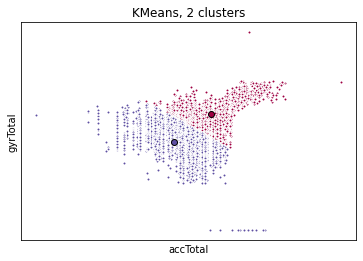

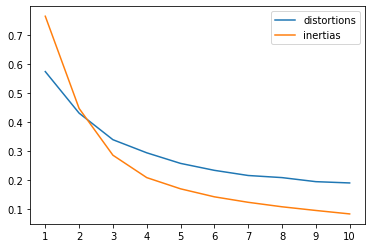

In [152]:
""" Using Kmeans """

kmeans_obj = K_Mean_Clustering(X_normal, ['accTotal','gyrTotal'])
kmeans_obj.FitModel()
kmeans_obj.plot()

kmeans_obj.evaluate()

Notes:
- elbow method seems to suggest that either two or 3 clusters are the best
- The visual for 2 clusters is not particularly reassuring...

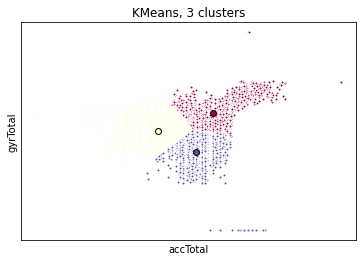

In [153]:
kmeans_obj.FitModel(n_clusters = 3)
kmeans_obj.plot()

Notes:
- 3 clusters not reassuring either
- 2 clusters is better

,accTotal,gyrTotal,labels
0,0.988180,1.243423,0
1,0.985190,2.613159,0
2,0.988888,5.775076,0
3,0.989596,12.620341,0
4,0.994686,49.341991,0


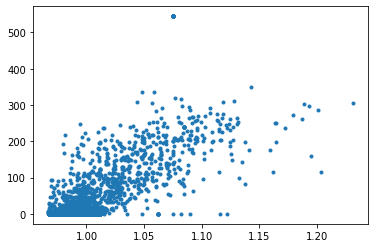

In [154]:
# redo fit for 2
kmeans_obj.FitModel()

# extract model and turn into dataframe
df_clustered = pd.DataFrame(data = normalizer.inverse_transform(X_normal), columns  = ['accTotal','gyrTotal'])

df_clustered['labels'] = kmeans_obj.model.labels_

#sanity check
plt.plot(df_clustered.accTotal,df_clustered.gyrTotal,'.')

df_clustered.head()

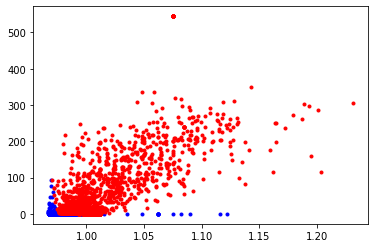

In [155]:
plt.plot(df_clustered.accTotal[df_clustered.labels == 1],df_clustered.gyrTotal[df_clustered.labels == 1],'b.')


plt.plot(df_clustered.accTotal[df_clustered.labels == 0],df_clustered.gyrTotal[df_clustered.labels == 0],'r.')

Notes:
- K means not a great method for this
- Now try with DBSCAN

# DBSCAN with 'normal' data

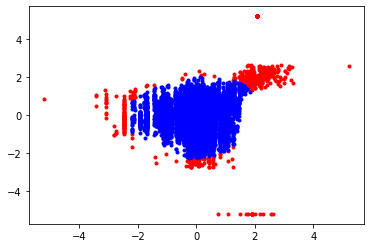

In [156]:
df_clustered[['accTotal','gyrTotal']] = normalizer.fit_transform(np.asarray(df_clustered[['accTotal','gyrTotal']]))

model = DBSCAN(eps = 1,min_samples = 2000, metric = 'euclidean').fit(X_normal)
model.labels_
true_false = []
for item in model.labels_:
    if item == 0:
        true_false.append(False)
    else:
        true_false.append(True)
        
anomalies = df_clustered[true_false]
actuals = df_clustered[[not i for i in true_false]]

plt.plot(anomalies.accTotal,anomalies.gyrTotal,'r.')
plt.plot(actuals.accTotal,actuals.gyrTotal,'b.')

Having tried the DBSCAN algorithm with a combination of different parameters (eps and min_samples), It seems to only capture the outliers, not the 'cap' or 'horn' of the shape!

However, it does seem to capture the 'outer' pieces of the shape, let's see what that looks like on a normal scale?

In [163]:
df_temp = pd.DataFrame(data = X, columns= [['accTotal','gyrTotal']])

        
anomalies = df_temp[true_false]
actuals = df_temp[[not i for i in true_false]]

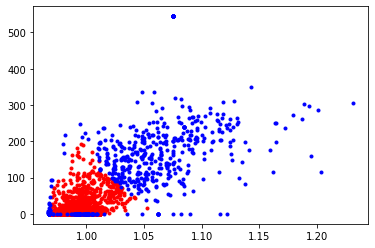

In [172]:
anom_acc = anomalies[anomalies.columns[0]].values
anom_gyr = anomalies[anomalies.columns[1]].values


act_acc = actuals[actuals.columns[0]].values
act_gyr = actuals[actuals.columns[1]].values


plt.plot(act_acc,act_gyr,'r.')
plt.plot(anom_acc,anom_gyr,'b.')



The same issue persists. This seems like an "ok" clustering method. Would like to verify this...
Not sure how yet.
Would like more data 

# Conclusion

I think that the major problem is still the lack of data. 

I'm not sure if the data that I currently have is sufficient. I still need to try other algorithms to see if they will lead to better performance, but for the time being, I guess an option for filtering data would be:
- only send data that has total acceleration > 1.02 and gyration > 100 degrees per second


NOTE:
- as far I'm aware DBSCAN can create more than 2 clusters, but it seems that all my attemps that far have created 2 clusters. This is particularly odd on the Normalized data which shows 3 clusters: the main body, the 'cap' and also the line at the buttom (gyration < -4 (in normalized scale)). 

The above makes me wonder if I've been doing it correctly... should investigate further.